In [1]:
%pip install matplotlib
%pip install numpy==1.23.5
%pip install opencv-python
%pip install medpy==0.4.0
%pip install tqdm
%matplotlib inline
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import os
plt.rcParams["figure.figsize"] = (15,15)

print(f"numpy version : {np.__version__}")

%load_ext autoreload
%autoreload 2

numpy version : 1.23.5


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
# from keras_unet.losses import dice_loss
# from keras_unet.metrics import dice_coef, iou, iou_thresholded
from keras_unet.visualization import plot_overlay_segmentation
from keras_unet.visualization import plot_compare_segmentation
from keras_unet.visualization import visualize_BestWorstOnes

# Add our own python modules stored in the folders present at the root level of this project
if "../" in sys.path: 
    print(sys.path)
else: 
    sys.path.append("../")
    print(sys.path)

if "model" in locals(): 
    print("deleting model")
    del model    
    
# Select the CPU device to run on
num_CPU = 1
num_cores = 8
tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

['c:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main', 'c:\\Users\\user\\anaconda3\\envs\\py310\\python310.zip', 'c:\\Users\\user\\anaconda3\\envs\\py310\\DLLs', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310', '', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\Pythonwin', '../']


## <span style="color:brown"> 1.1) Load data

In [18]:
from keras_unet.utils import load_CAMUS_dataset

# Parameters
IMG_SIZE = 256  # All the images will be resized to IMG_SIZE x IMG_SIZE to speed up the process. 

dataset_train_path = "dataset/segmentation/train/"
dataset_valid_path = "dataset/segmentation/valid/"
dataset_test_path = "dataset/segmentation/test/"

# Load data
[X_train_C, y_train_C] = load_CAMUS_dataset(dataset_train_path, IMG_SIZE)
[X_valid_C, y_valid_C] = load_CAMUS_dataset(dataset_valid_path, IMG_SIZE)
[X_test_C, y_test_C] = load_CAMUS_dataset(dataset_test_path, IMG_SIZE)

# Deleting the last dimension's index=1
y_train_C = np.delete(y_train_C, 1, axis=3)
print(y_train_C.shape)

y_valid_C = np.delete(y_valid_C, 1, axis=3)
print(y_valid_C.shape)

y_test_C = np.delete(y_test_C, 1, axis=3)
print(y_test_C.shape)

from keras_unet.utils import load_SUMAC_dataset
dataset_dir = "./dataset/sumac_256/"
X_S, y_S = load_SUMAC_dataset(dataset_dir, img_size=256, 
                          extension="nii.gz",random_state=42)

from sklearn.model_selection import train_test_split
import numpy as np

# 假设 X_S 和 y_S 是原始的特征集和标签集
# 首先创建一个包含400个样本的初始训练集
X_train_S800, X_temp, y_train_S800, y_temp = train_test_split(X_S, y_S, test_size=0.2, random_state=42)
X_test_SA, X_valid_SA, y_test_SA, y_valid_SA = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


100%|██████████| 100/100 [00:00<00:00, 4013.04it/s]


(800, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)


100%|██████████| 1000/1000 [00:02<00:00, 426.32it/s]


In [29]:
from tqdm import tqdm
import cv2
import SimpleITK as sitk
from keras_unet.utils import load_CAMUS_dataset,ReadMasksNIIGZ

def ReadImagesNIIGZ(images_files, size, crop=None):
    X = []
    for index in tqdm(range(len(images_files))):
        image_read = sitk.GetArrayFromImage(sitk.ReadImage(images_files[index]))
        if crop is not None:
            image_read = image_read[crop[0]:crop[2],crop[1]:crop[3]]
        image_read = cv2.resize(image_read, dsize = size, interpolation = cv2.INTER_LINEAR)
        image_read = image_read / 255.0
        X.append(image_read)
    X = np.asarray(X, dtype=np.float32)
    X = np.expand_dims(X,-1)
    return X

In [30]:
test_path = "./VAE/sumac_test_paths.txt"

test_img_paths = []
test_mask_paths = []

# Open the file in read mode
with open(test_path, 'r') as file:
    for line in file:
        # Replace '../' with './'
        line_modified = line.strip().replace('../', './')

        # Replace 'mask' with 'img' for image paths, and adjust the directory
        img_path = line_modified.replace('sumac_64', 'sumac_256')
        
        # Adjust the directory for mask paths
        mask_path = line_modified.replace('img', 'mask').replace('sumac_64', 'sumac_256')

        test_img_paths.append(img_path)
        test_mask_paths.append(mask_path)

# Print the lists of paths
print("Image Paths:", test_img_paths)
print("Mask Paths:", test_mask_paths)

X_test_SV = ReadImagesNIIGZ(test_img_paths, (IMG_SIZE, IMG_SIZE), crop=None)
X_test_SV.shape, X_test_SV.min(), X_test_SV.max()
y_test_SV = ReadMasksNIIGZ(test_mask_paths, (IMG_SIZE, IMG_SIZE), crop=None)
y_test_SV.shape, y_test_SV.min(), y_test_SV.max()

Image Paths: ['./dataset/sumac_256/di-D022-B117-2BC4\\di-D022-B117-2BC4_img_ES.nii.gz', './dataset/sumac_256/di-8D19-333B-39D3\\di-8D19-333B-39D3_img_ES.nii.gz', './dataset/sumac_256/di-4348-4C59-97A7\\di-4348-4C59-97A7_img_ES.nii.gz', './dataset/sumac_256/di-D180-F7B6-FF74\\di-D180-F7B6-FF74_img_ED.nii.gz', './dataset/sumac_256/di-B189-4472-2C19\\di-B189-4472-2C19_img_ED.nii.gz', './dataset/sumac_256/di-DA90-DE4B-D0D6\\di-DA90-DE4B-D0D6_img_ED.nii.gz', './dataset/sumac_256/di-9A58-0A22-0160\\di-9A58-0A22-0160_img_ES.nii.gz', './dataset/sumac_256/di-F2C4-991D-584A\\di-F2C4-991D-584A_img_ES.nii.gz', './dataset/sumac_256/di-3D69-7848-EFD3\\di-3D69-7848-EFD3_img_ES.nii.gz', './dataset/sumac_256/di-1082-2DFF-FEA1\\di-1082-2DFF-FEA1_img_ED.nii.gz', './dataset/sumac_256/di-5B66-0B58-6793\\di-5B66-0B58-6793_img_ED.nii.gz', './dataset/sumac_256/di-82EC-5EA5-912E\\di-82EC-5EA5-912E_img_ED.nii.gz', './dataset/sumac_256/di-D741-C859-1658\\di-D741-C859-1658_img_ES.nii.gz', './dataset/sumac_256/di-

100%|██████████| 100/100 [00:00<00:00, 374.92it/s]


((100, 256, 256, 3), 0.0, 1.0)

## Load a trained model

# Prediction

In [36]:
from tensorflow.keras import models
from keras_unet.losses import dice_loss
from keras_unet.metrics import dice_coef 
import pandas as pd
from IPython.display import display, HTML 
import matplotlib.pyplot as plt
from keras_unet.evaluation import evaluate_set

sizes0 = [800, 700, 600, 500, 400, 300, 200, 100, 70, 50, 30, 20, 10, 0]

def EvaluateSUAMC(X, y, model_path, size):
    model = models.load_model(model_path, custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})
    X_picked = X[:1000,]
    y_picked = y[:1000]

    y_pred = model.predict(X_picked, batch_size=1, verbose=1)
    if size in [1, 0]:
        y_pred[:, :, :, [1, 2]] = y_pred[:, :, :, [2, 1]]
    dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y[:1000, ], y_pred[:1000, ])

    overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
    overall_results_df = pd.DataFrame(data=overall_results, 
                                      index=["All", "Myocardium", "Left Ventricle"], 
                                      columns=["Dice", "Hausdorff (px)", "ASSD (px)"])

    title = f'SUMAC Dataset - Size {size}'
    display(HTML(f'<h3>{title}</h3>'))
    display(HTML(overall_results_df.to_html(float_format=lambda x: '%.2f' % x)))
    overall_results_df.plot(kind='bar', figsize=(8,4)).legend()
    plt.show()
    
    return dice_all[0]

def EvaluateCAMUS(X, y, model_path, size):
    model = models.load_model(model_path, custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})
    X_picked = X[:1000,]
    y_picked = y[:1000]

    y_pred = model.predict(X_picked, batch_size=1, verbose=1)
    dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y[:1000, ], y_pred[:1000, ])

    overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
    overall_results_df = pd.DataFrame(data=overall_results, 
                                      index=["All", "Myocardium", "Left Ventricle"], 
                                      columns=["Dice", "Hausdorff (px)", "ASSD (px)"])

    title = f'CAMUS Dataset - Size {size}'
    display(HTML(f'<h3>{title}</h3>'))
    display(HTML(overall_results_df.to_html(float_format=lambda x: '%.2f' % x)))
    overall_results_df.plot(kind='bar', figsize=(8,4)).legend()
    plt.show()
    
    return dice_all[0]



100/100 [==============================] - 1s 9ms/step


100%|██████████| 100/100 [00:02<00:00, 37.71it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.92,6.92,1.76
Myocardium,0.94,5.15,1.77
Left Ventricle,0.90,6.84,1.74


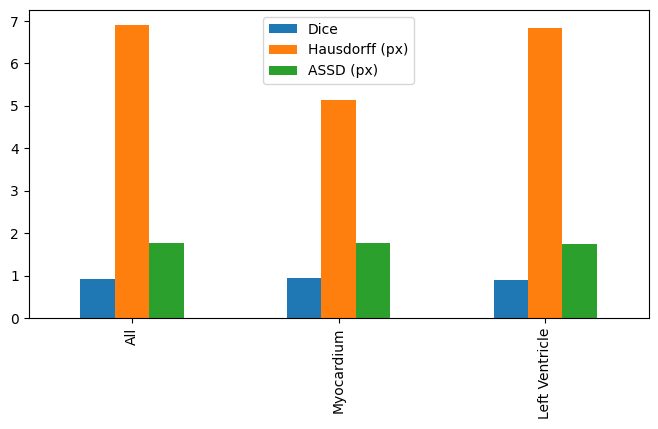

100/100 [==============================] - 1s 9ms/step


100%|██████████| 100/100 [00:02<00:00, 35.62it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.10,2.25
Myocardium,0.88,8.79,2.27
Left Ventricle,0.94,7.70,2.22


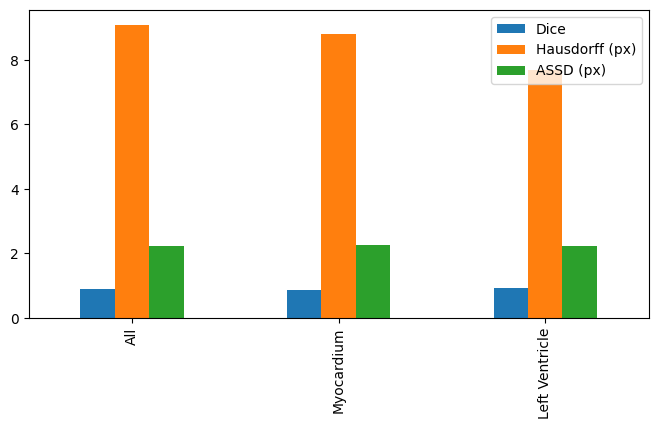

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.94,5.43,1.19
Myocardium,0.96,3.70,1.14
Left Ventricle,0.93,5.42,1.24


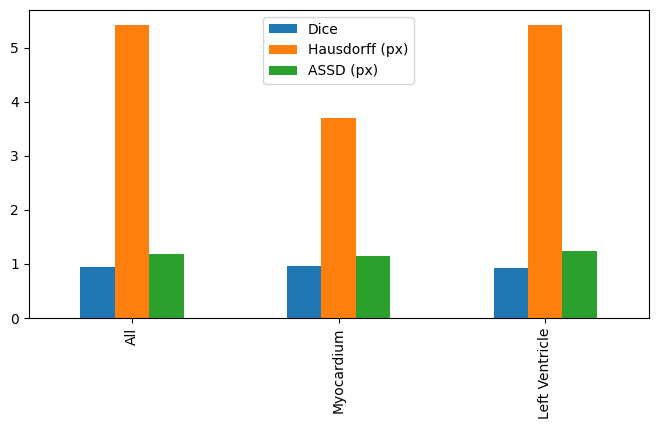

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:03<00:00, 33.10it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,10.97,2.19
Myocardium,0.88,10.85,2.16
Left Ventricle,0.93,7.35,2.23


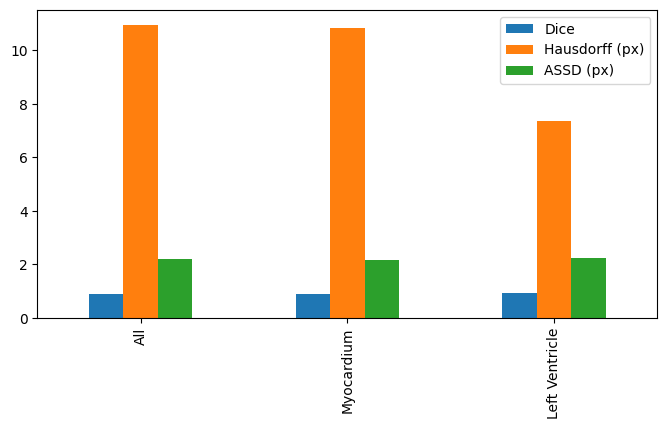

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 36.18it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.95,4.07,1.04
Myocardium,0.96,3.34,1.02
Left Ventricle,0.94,4.03,1.06


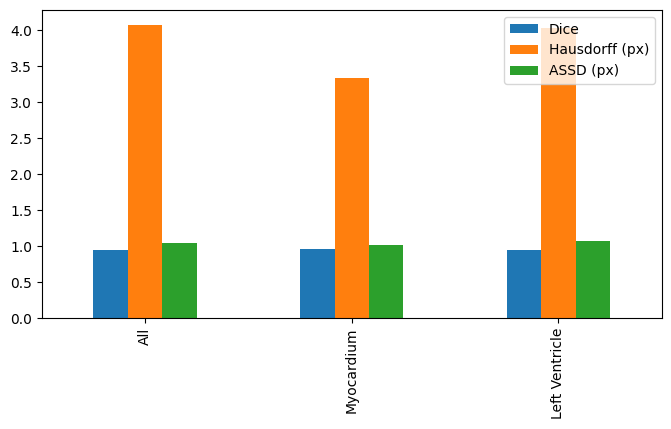

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.03,2.17
Myocardium,0.88,8.97,2.20
Left Ventricle,0.94,7.14,2.14


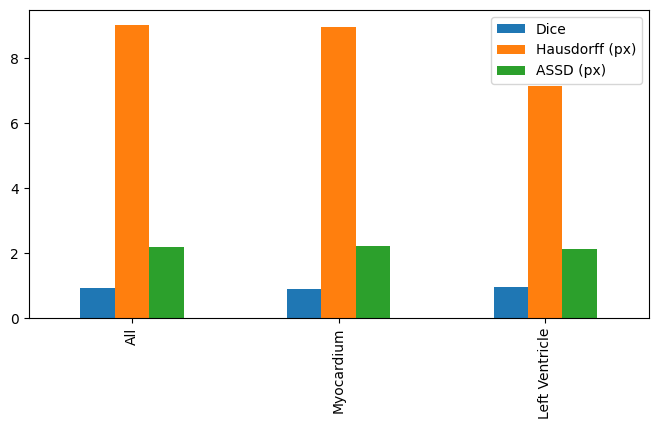

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 35.00it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,7.94,2.00
Myocardium,0.93,5.86,2.02
Left Ventricle,0.89,7.76,1.97


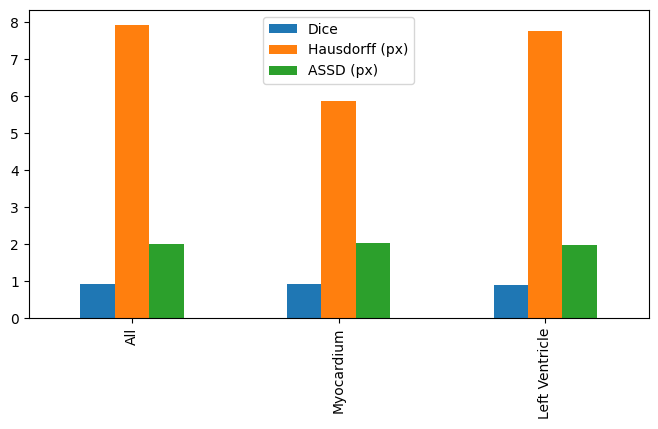

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.16,2.30
Myocardium,0.88,8.94,2.29
Left Ventricle,0.93,7.60,2.31


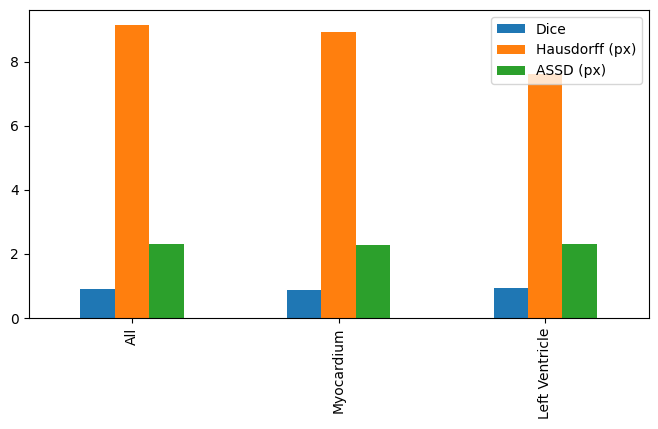

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.03it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.93,6.27,1.49
Myocardium,0.94,4.83,1.53
Left Ventricle,0.92,6.18,1.45


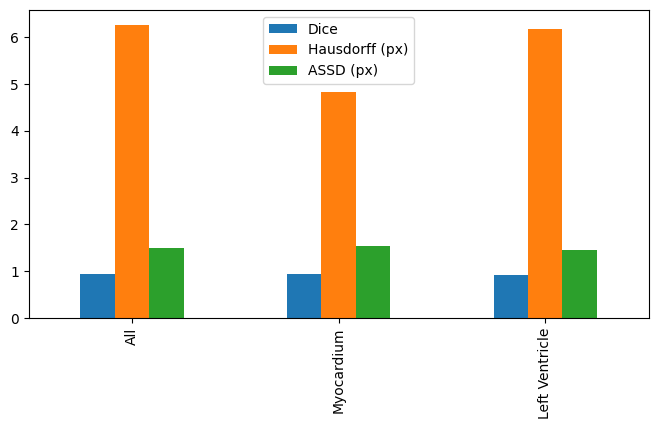

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 35.46it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.05,2.24
Myocardium,0.88,8.67,2.22
Left Ventricle,0.93,7.59,2.26


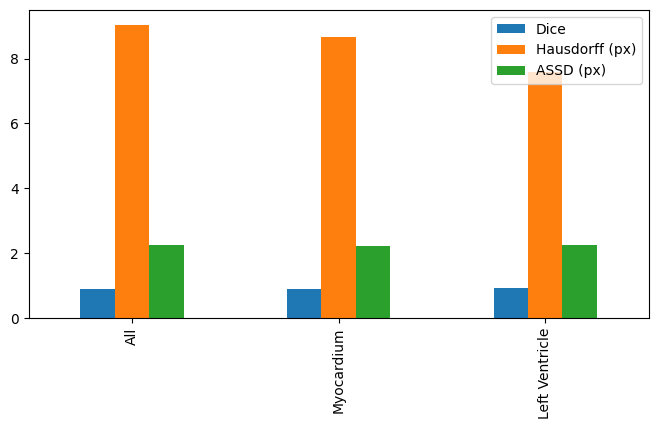

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 33.74it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,10.65,2.22
Myocardium,0.92,7.68,2.18
Left Ventricle,0.88,10.59,2.26


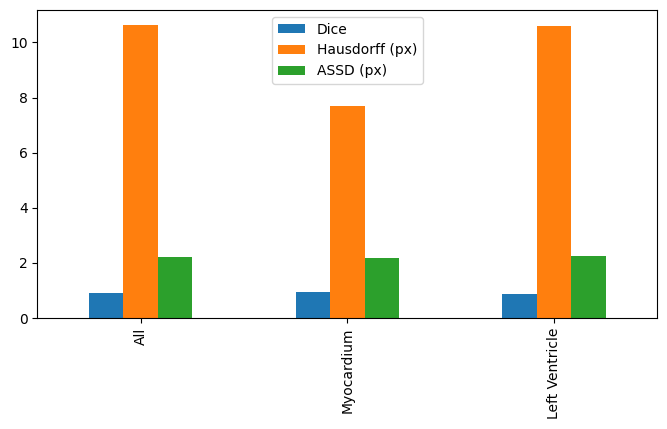

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:03<00:00, 32.79it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,9.76,2.34
Myocardium,0.87,9.29,2.28
Left Ventricle,0.93,8.10,2.41


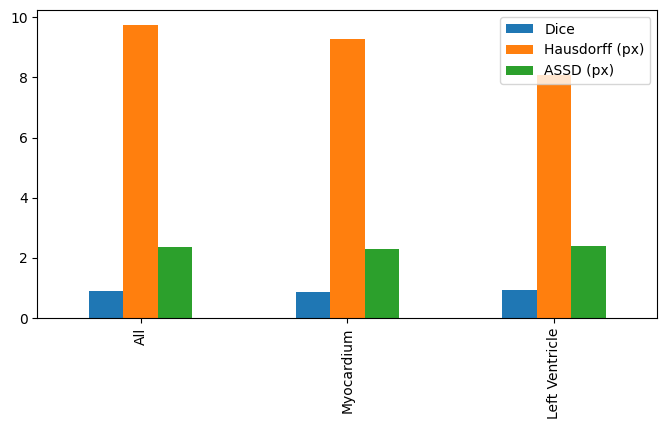

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 35.42it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.92,7.15,1.77
Myocardium,0.94,5.21,1.72
Left Ventricle,0.90,7.05,1.82


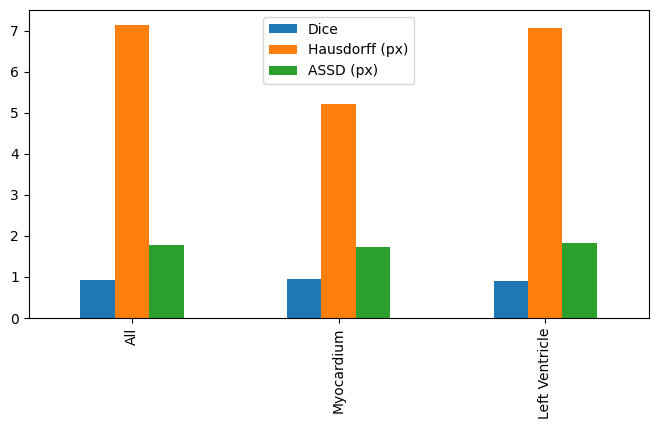

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 36.98it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.60,2.13
Myocardium,0.88,8.50,2.20
Left Ventricle,0.94,6.95,2.06


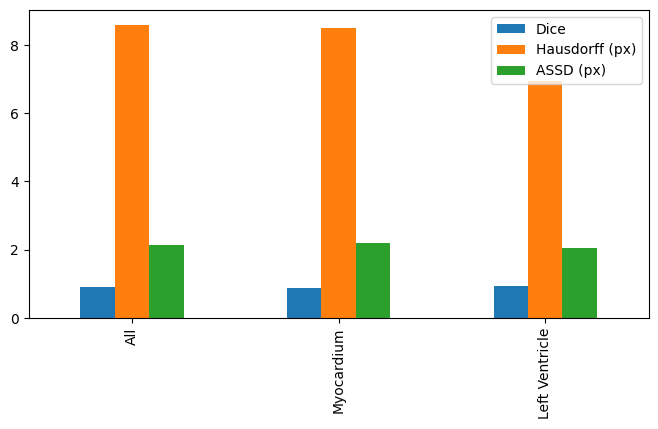

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.79it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.93,5.72,1.38
Myocardium,0.95,4.29,1.36
Left Ventricle,0.92,5.69,1.41


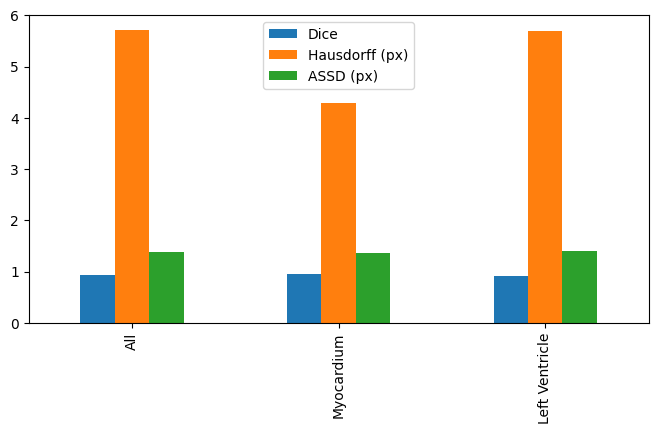

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.24it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,9.42,2.39
Myocardium,0.87,9.33,2.33
Left Ventricle,0.93,7.95,2.46


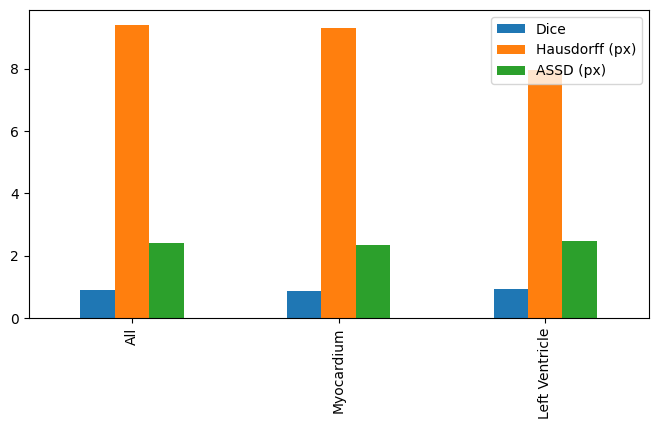

100/100 [==============================] - 2s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.84it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.94,4.73,1.22
Myocardium,0.96,3.85,1.21
Left Ventricle,0.93,4.72,1.24


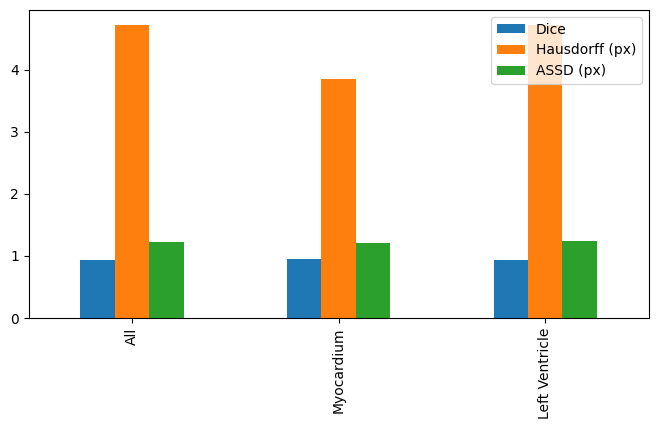

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.59it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.05,2.20
Myocardium,0.88,8.75,2.23
Left Ventricle,0.94,7.28,2.18


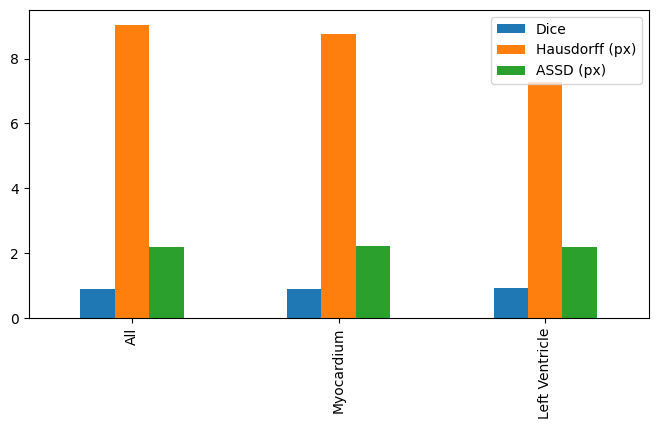

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.89,10.38,2.27
Myocardium,0.92,6.97,2.26
Left Ventricle,0.88,9.90,2.28


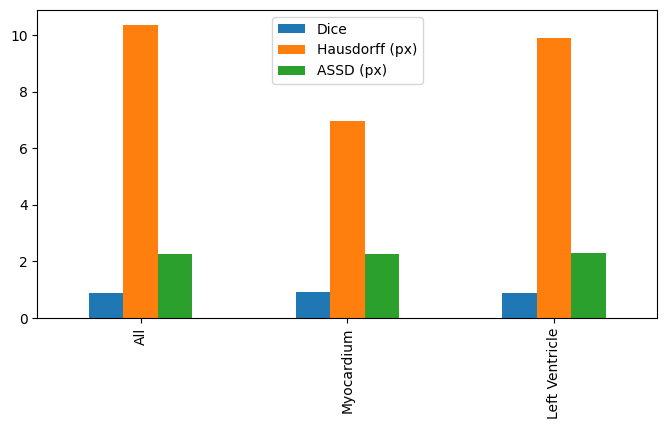

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.84it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.06,2.17
Myocardium,0.88,9.03,2.17
Left Ventricle,0.94,7.00,2.17


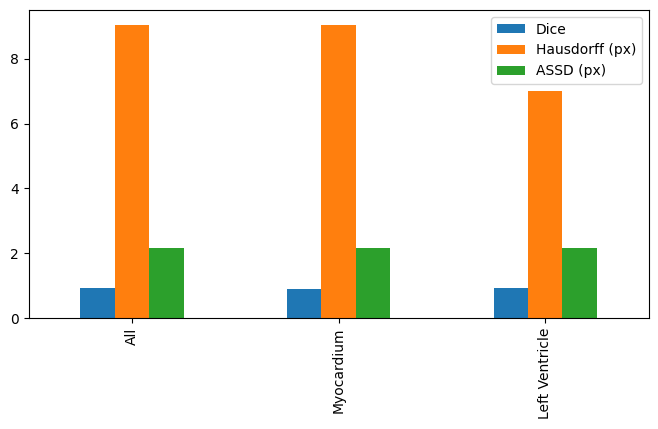

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 36.75it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.92,7.45,1.63
Myocardium,0.94,6.09,1.69
Left Ventricle,0.91,6.67,1.56


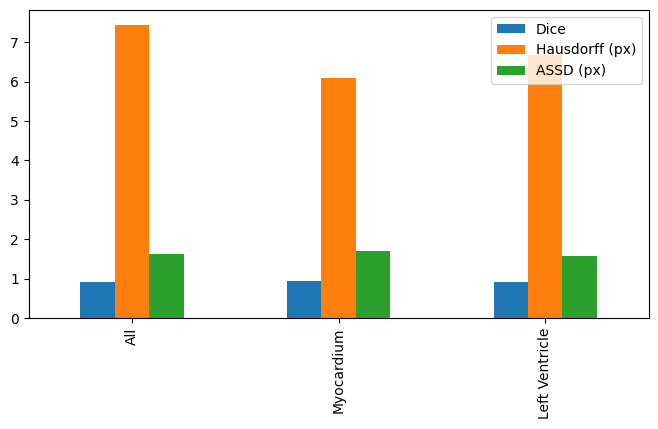

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.24it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,9.46,2.33
Myocardium,0.87,9.27,2.29
Left Ventricle,0.93,7.94,2.36


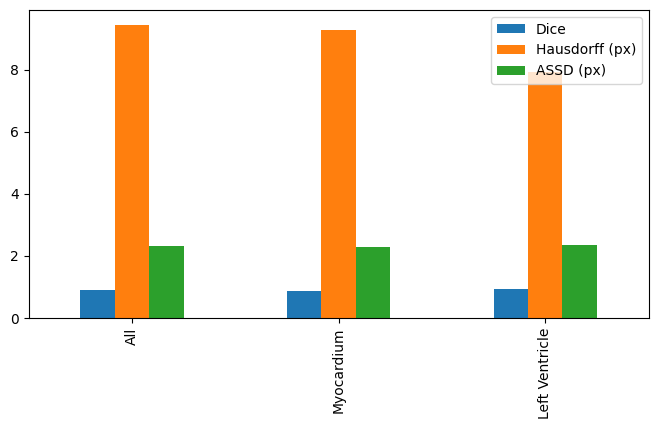

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.93,5.62,1.38
Myocardium,0.95,4.64,1.39
Left Ventricle,0.92,5.12,1.38


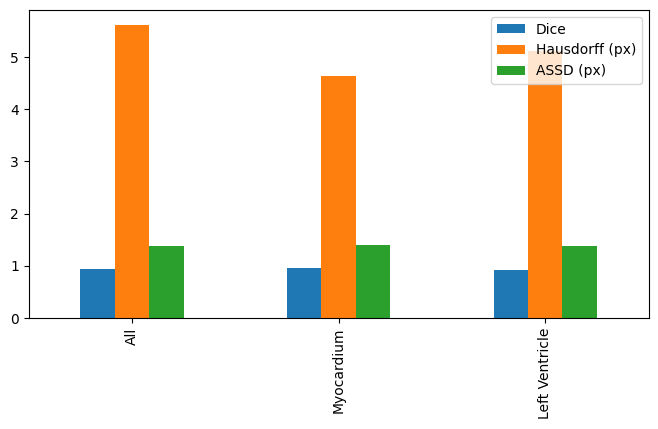

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.68it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.84,2.16
Myocardium,0.88,8.76,2.19
Left Ventricle,0.94,7.27,2.14


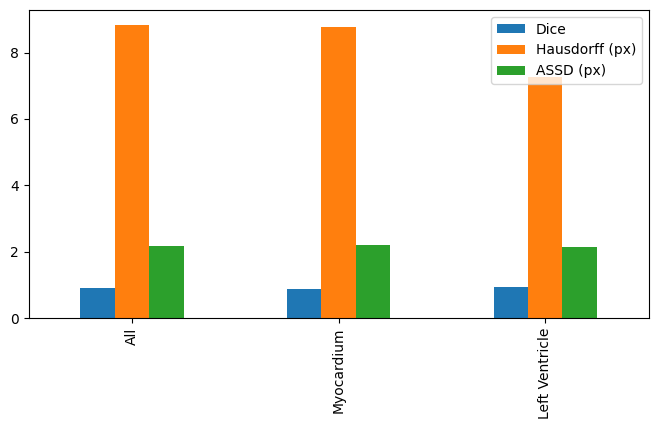

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 39.10it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,7.25,1.85
Myocardium,0.93,5.47,1.80
Left Ventricle,0.89,7.18,1.90


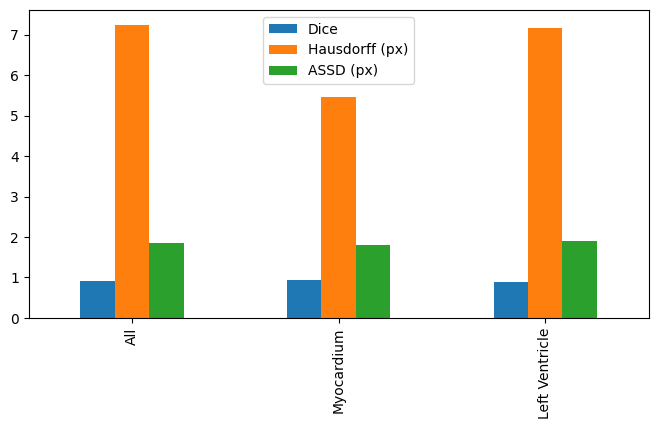

100/100 [==============================] - 2s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.56,2.12
Myocardium,0.88,8.51,2.15
Left Ventricle,0.94,6.91,2.08


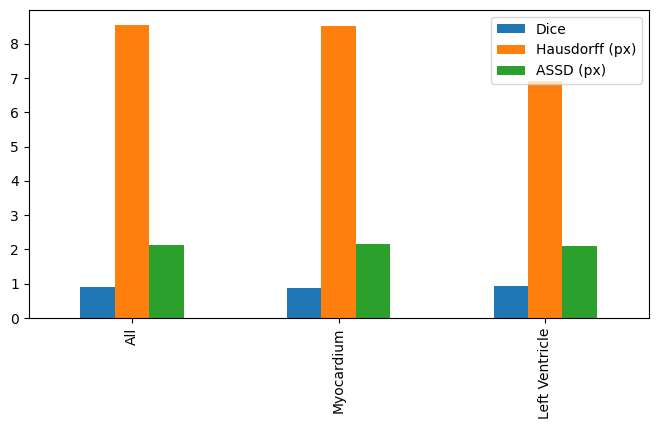

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.31it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.92,8.75,1.64
Myocardium,0.94,5.02,1.59
Left Ventricle,0.91,8.71,1.68


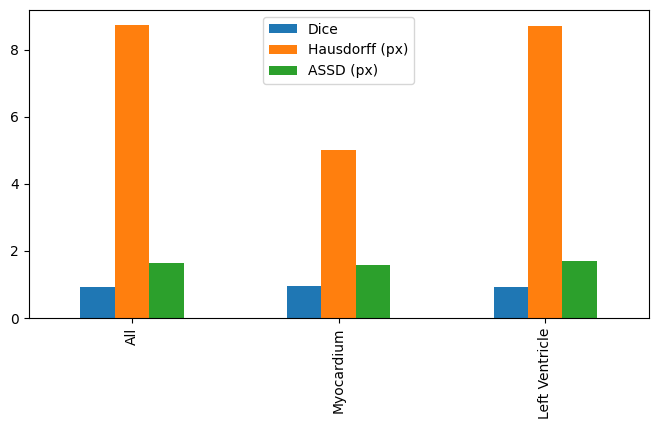

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.53it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,11.17,2.34
Myocardium,0.87,9.63,2.31
Left Ventricle,0.93,8.92,2.36


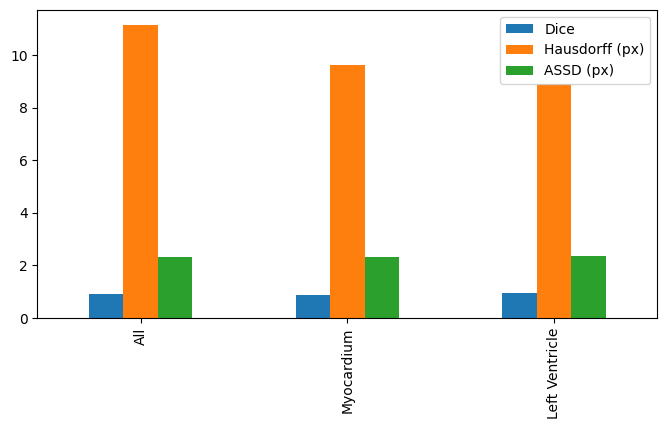

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.56it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.93,7.14,1.52
Myocardium,0.95,5.36,1.52
Left Ventricle,0.91,6.31,1.52


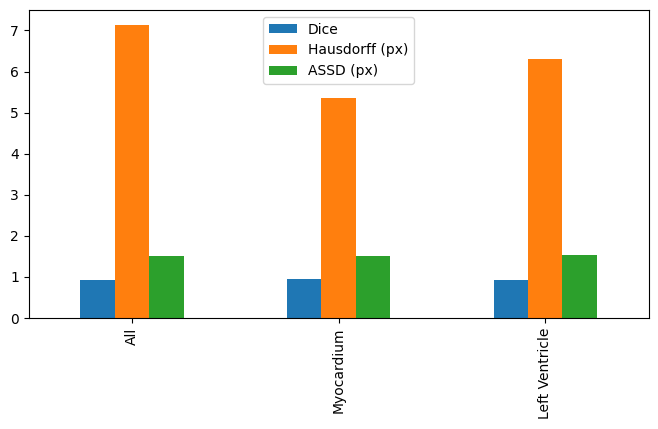

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.84it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.84,2.18
Myocardium,0.88,8.73,2.15
Left Ventricle,0.94,7.13,2.20


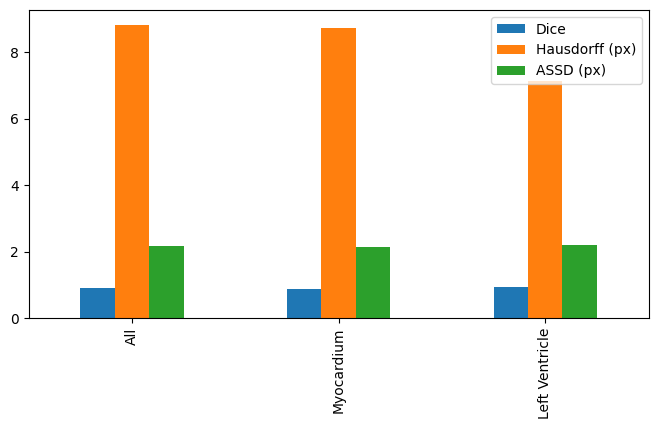

100/100 [==============================] - 1s 9ms/step


100%|██████████| 100/100 [00:02<00:00, 36.72it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.42,1.97
Myocardium,0.93,6.74,2.00
Left Ventricle,0.89,8.34,1.94


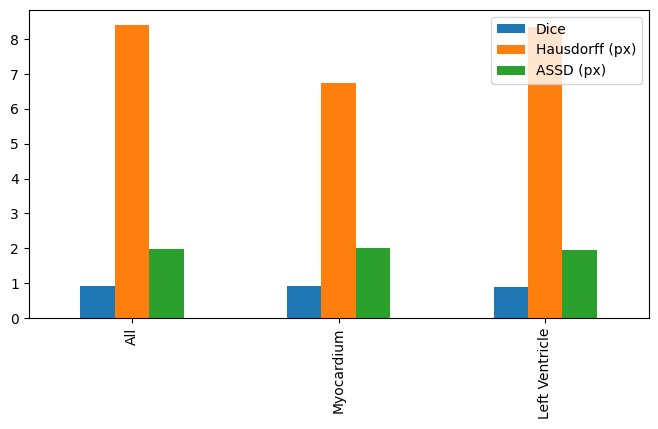

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:03<00:00, 31.85it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.43,2.18
Myocardium,0.88,9.05,2.15
Left Ventricle,0.94,7.75,2.20


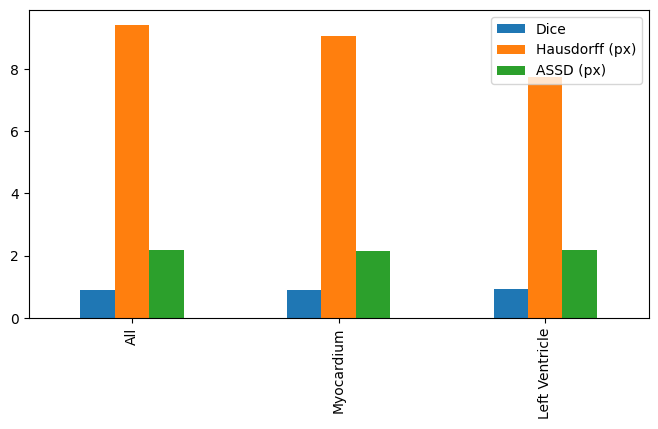

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.56it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.92,7.07,1.68
Myocardium,0.94,5.14,1.67
Left Ventricle,0.91,6.99,1.68


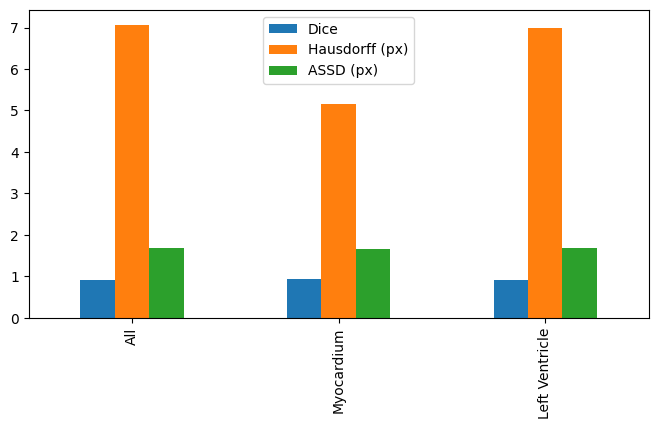

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.10,2.23
Myocardium,0.87,9.02,2.25
Left Ventricle,0.94,7.40,2.21


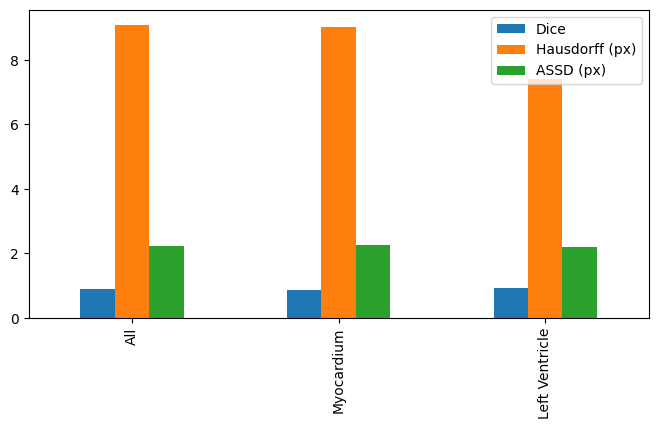

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.48,1.92
Myocardium,0.93,6.15,1.91
Left Ventricle,0.89,7.94,1.93


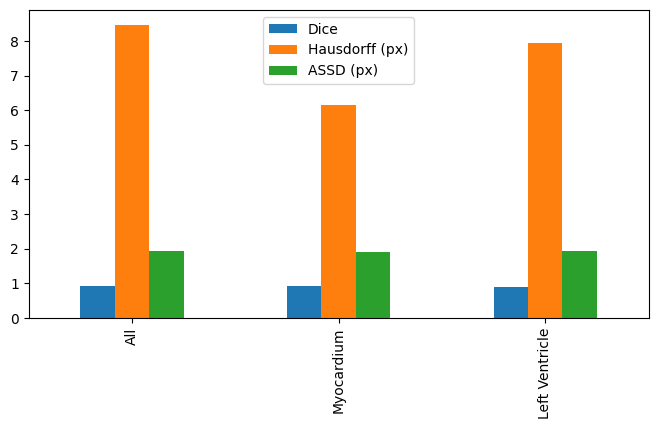

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.85it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.16,2.19
Myocardium,0.87,9.15,2.25
Left Ventricle,0.94,7.16,2.13


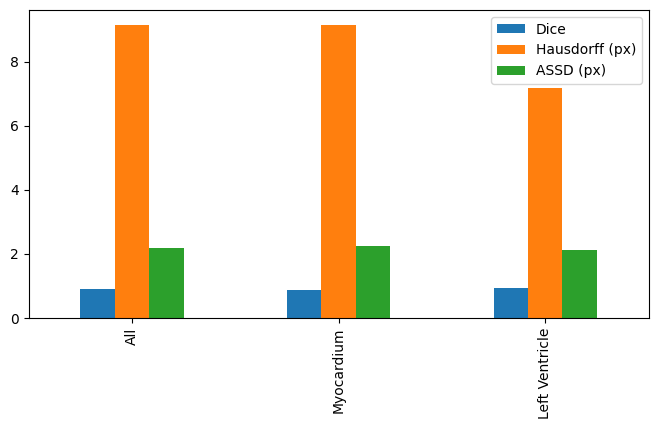

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.91it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,8.55,2.01
Myocardium,0.93,6.56,2.00
Left Ventricle,0.88,8.01,2.03


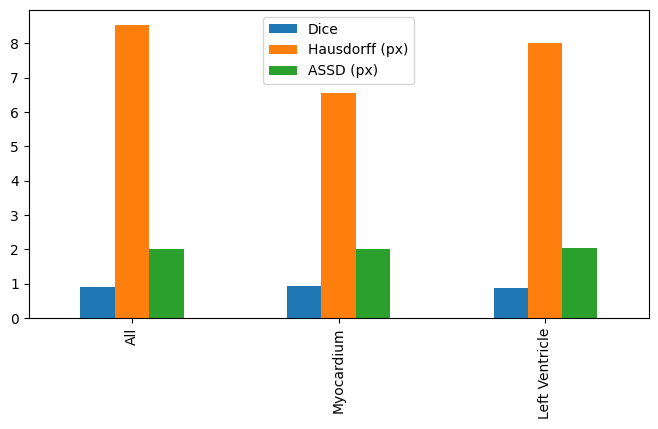

100/100 [==============================] - 1s 9ms/step


100%|██████████| 100/100 [00:02<00:00, 36.59it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.80,2.22
Myocardium,0.87,8.74,2.26
Left Ventricle,0.94,7.20,2.19


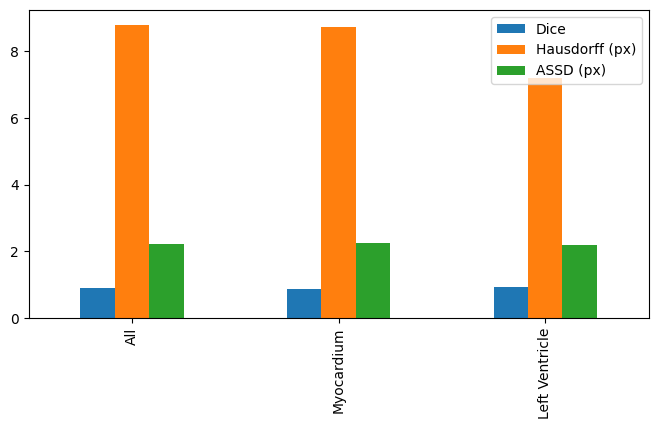

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.59,1.83
Myocardium,0.94,7.46,1.84
Left Ventricle,0.90,8.36,1.83


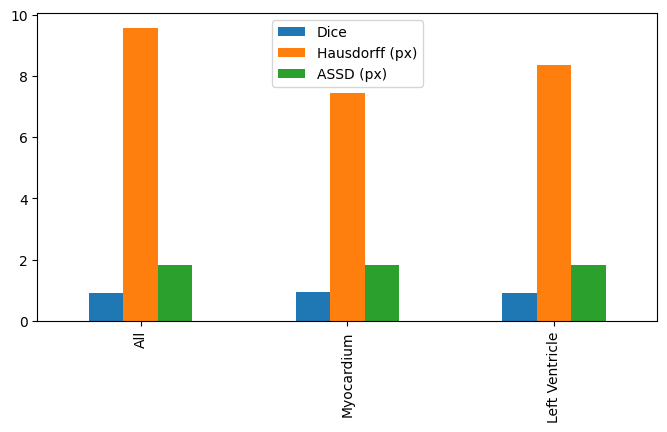

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 35.91it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.29,2.16
Myocardium,0.88,8.23,2.21
Left Ventricle,0.94,6.93,2.11


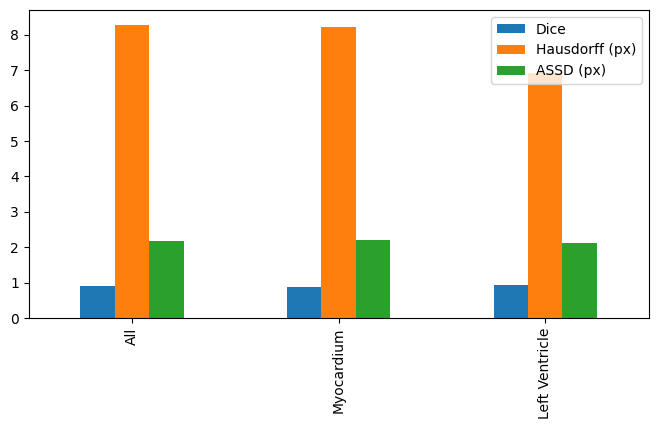

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.25it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.92,12.37,1.81
Myocardium,0.94,6.79,1.76
Left Ventricle,0.90,11.07,1.86


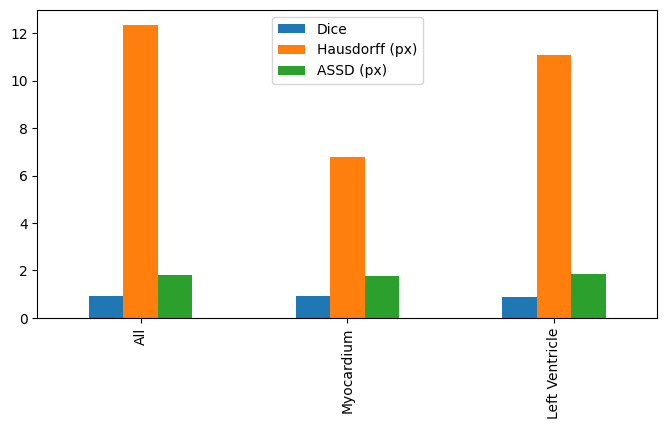

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.05it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.67,2.18
Myocardium,0.88,8.60,2.24
Left Ventricle,0.94,6.95,2.12


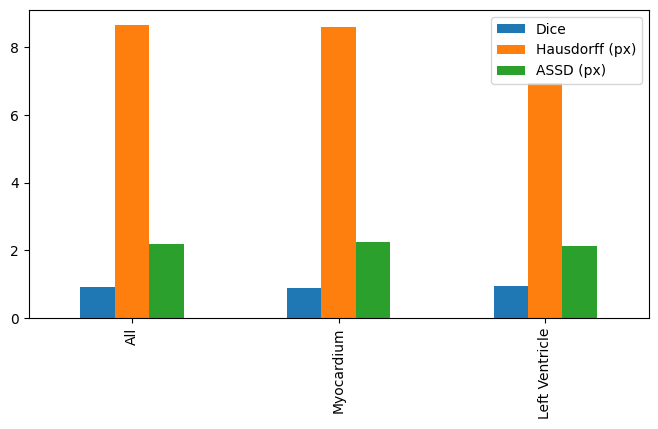

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.89,14.79,2.59
Myocardium,0.91,10.34,2.58
Left Ventricle,0.87,13.97,2.60


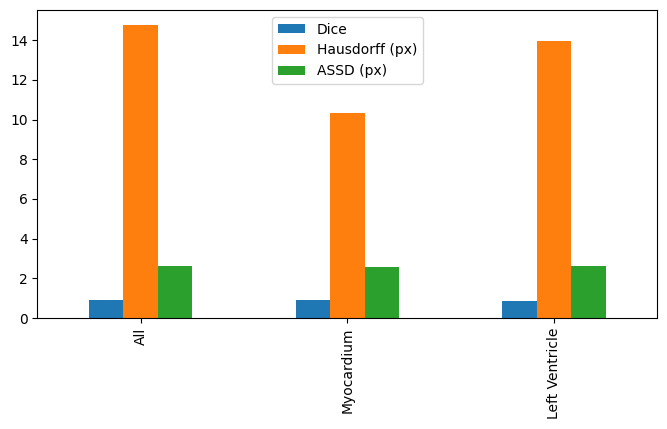

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.91,2.15
Myocardium,0.88,8.80,2.23
Left Ventricle,0.94,7.11,2.08


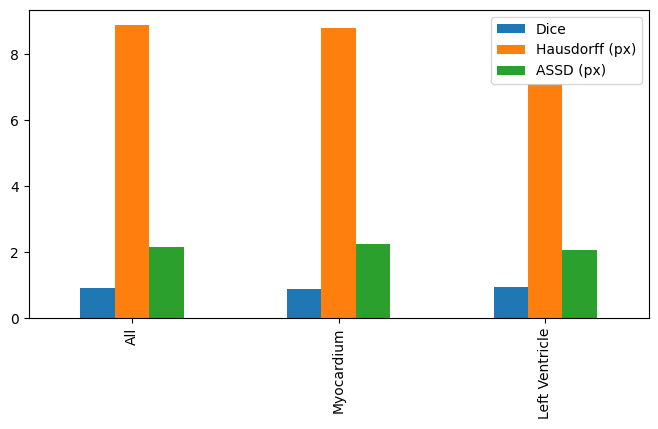

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.28it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.89,12.07,2.27
Myocardium,0.92,7.68,2.23
Left Ventricle,0.87,11.65,2.32


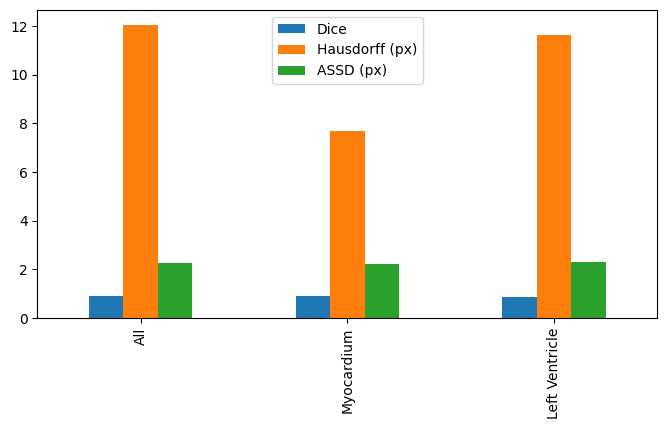

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.32it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.64,2.23
Myocardium,0.87,8.50,2.24
Left Ventricle,0.94,7.32,2.21


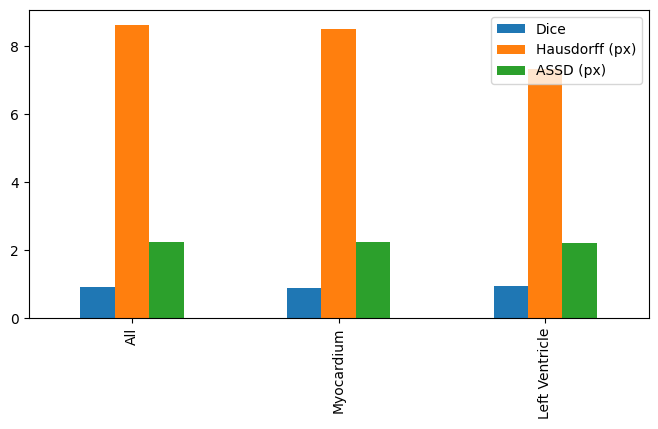

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 35.47it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.89,13.59,2.43
Myocardium,0.92,10.48,2.41
Left Ventricle,0.87,11.60,2.45


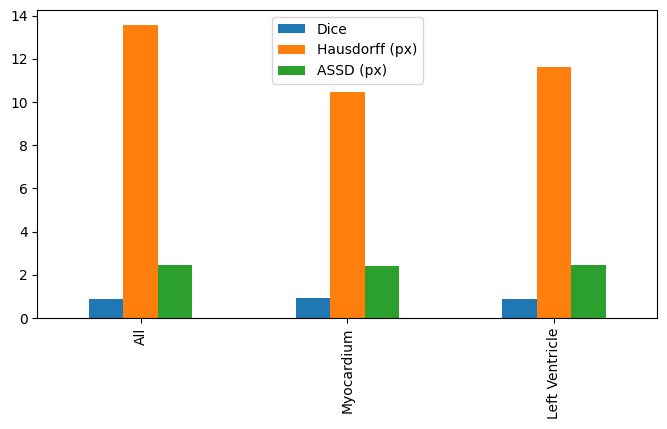

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 35.40it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.83,2.27
Myocardium,0.87,8.74,2.25
Left Ventricle,0.93,7.58,2.28


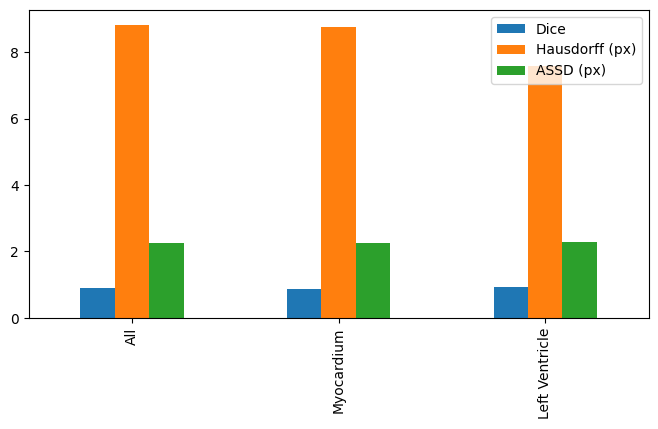

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.22it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.87,15.32,2.79
Myocardium,0.90,11.23,2.84
Left Ventricle,0.85,13.89,2.75


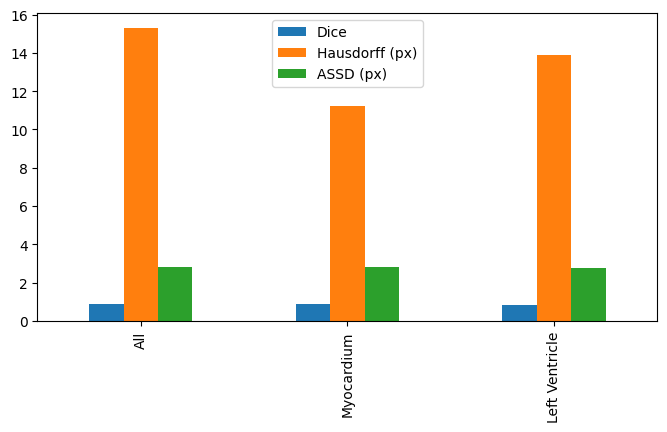

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.30it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.11,2.20
Myocardium,0.88,9.02,2.25
Left Ventricle,0.94,7.08,2.16


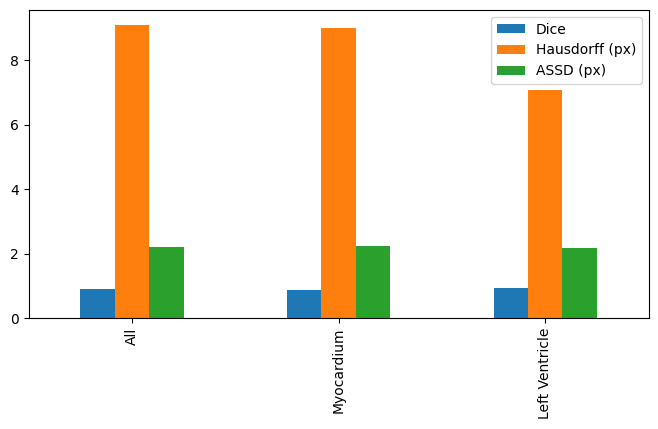

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.18it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.89,12.48,2.38
Myocardium,0.91,8.70,2.37
Left Ventricle,0.87,12.17,2.40


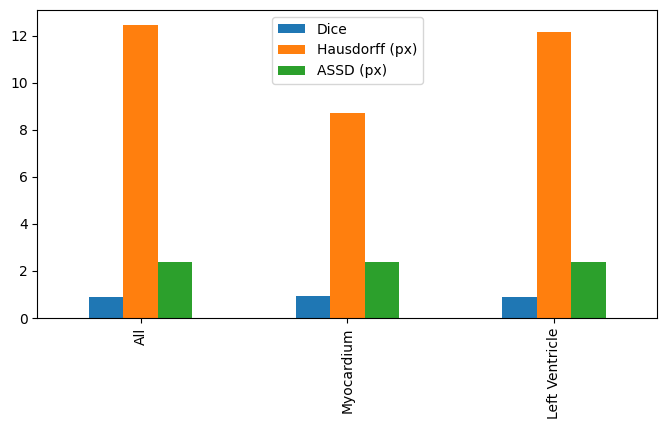

100/100 [==============================] - 2s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 35.56it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,8.89,2.23
Myocardium,0.87,8.85,2.31
Left Ventricle,0.94,7.31,2.15


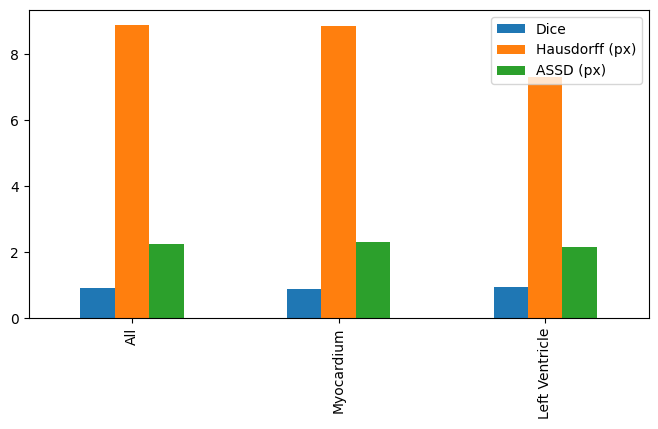

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.11it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.87,14.00,2.61
Myocardium,0.90,10.33,2.62
Left Ventricle,0.86,12.61,2.60


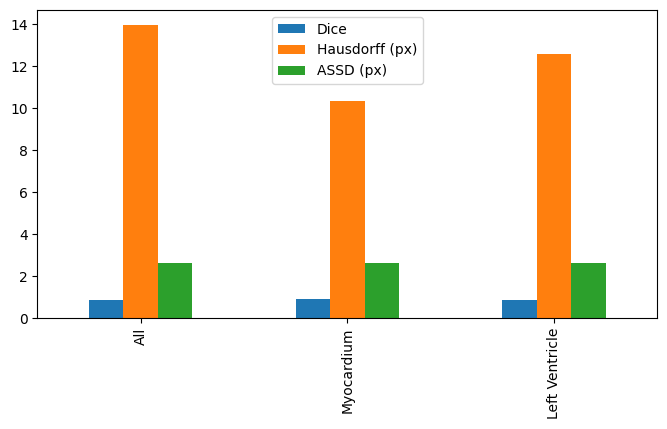

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.70,2.20
Myocardium,0.88,8.64,2.25
Left Ventricle,0.94,7.11,2.14


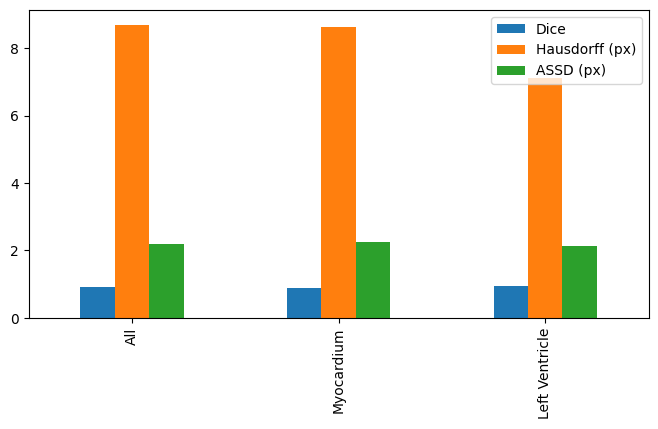

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 36.29it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.86,17.46,3.02
Myocardium,0.88,11.87,3.03
Left Ventricle,0.84,16.53,3.02


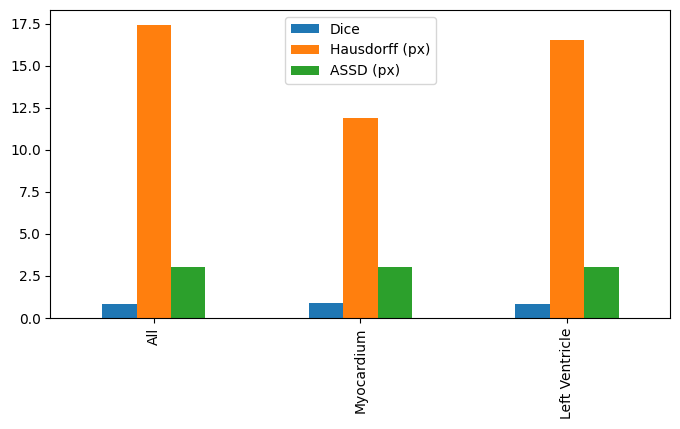

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 35.50it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.87,2.22
Myocardium,0.87,8.83,2.30
Left Ventricle,0.94,6.94,2.14


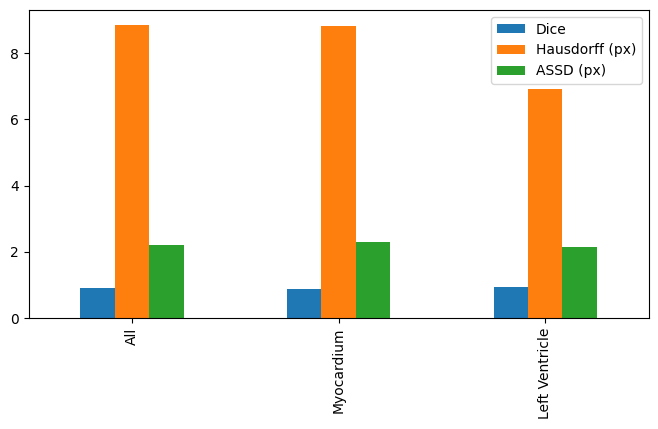

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.71it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.88,13.63,2.62
Myocardium,0.91,9.24,2.59
Left Ventricle,0.86,13.07,2.65


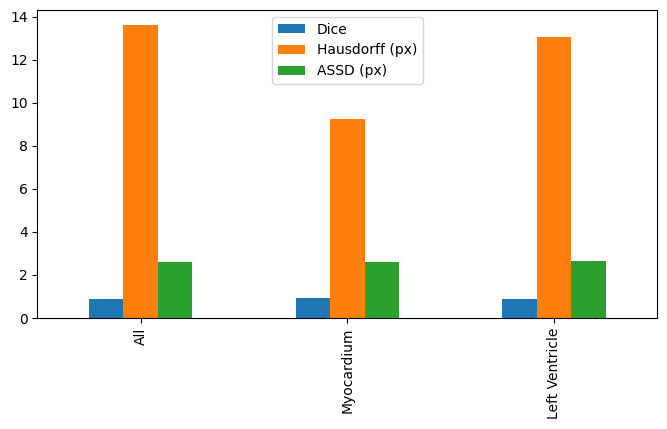

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 37.73it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.68,2.17
Myocardium,0.88,8.65,2.24
Left Ventricle,0.94,7.16,2.11


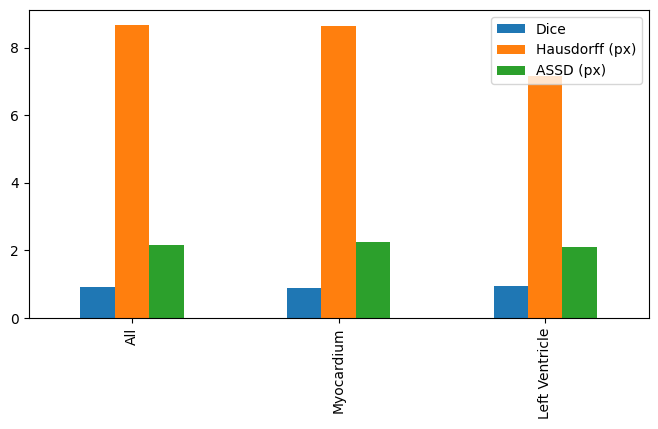

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.87,19.16,2.96
Myocardium,0.90,15.44,3.06
Left Ventricle,0.85,16.22,2.87


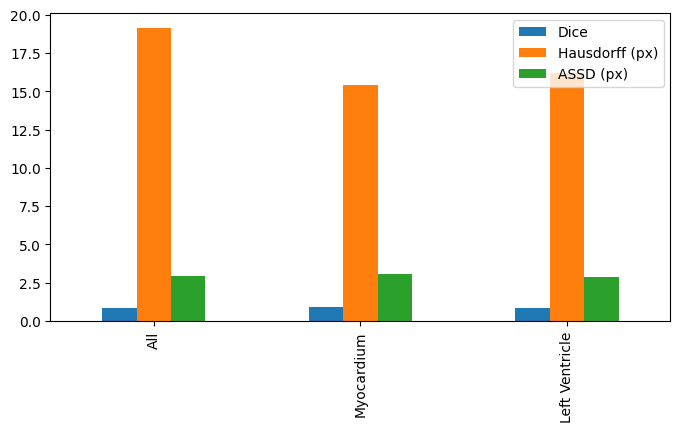

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.53it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.86,2.19
Myocardium,0.88,8.67,2.23
Left Ventricle,0.94,7.32,2.16


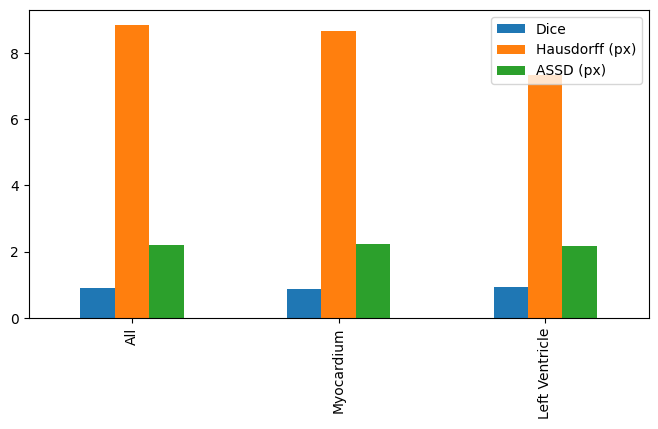

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 39.79it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.84,20.96,3.45
Myocardium,0.86,15.53,3.52
Left Ventricle,0.82,19.63,3.39


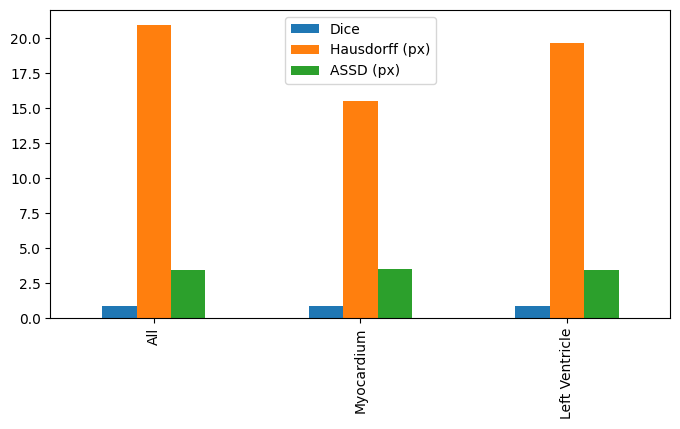

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.97it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.81,2.20
Myocardium,0.87,8.65,2.26
Left Ventricle,0.94,7.12,2.15


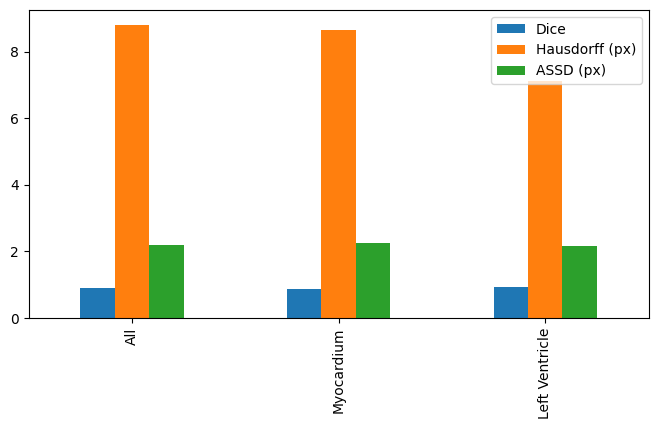

100/100 [==============================] - 3s 12ms/step


100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.86,20.80,3.23
Myocardium,0.89,12.71,3.18
Left Ventricle,0.83,19.50,3.27


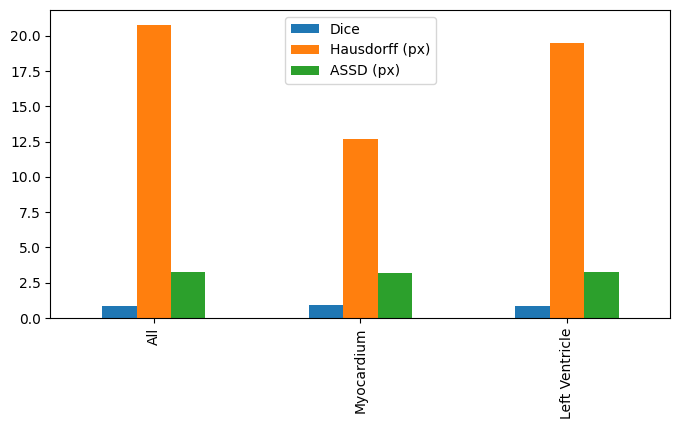

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.80it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.15,2.13
Myocardium,0.88,8.88,2.19
Left Ventricle,0.94,7.18,2.07


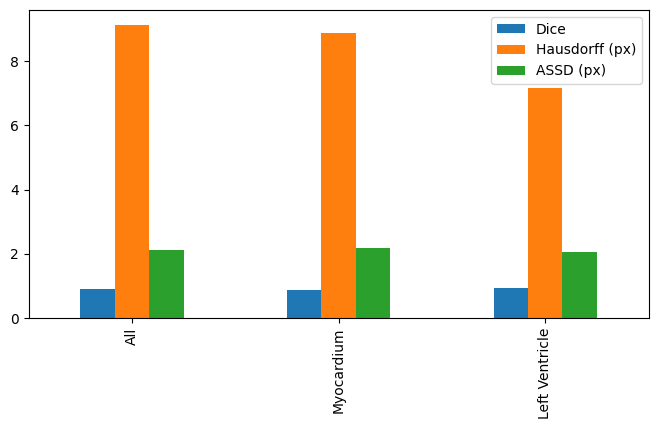

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.84,20.51,3.52
Myocardium,0.85,14.68,3.68
Left Ventricle,0.82,18.72,3.37


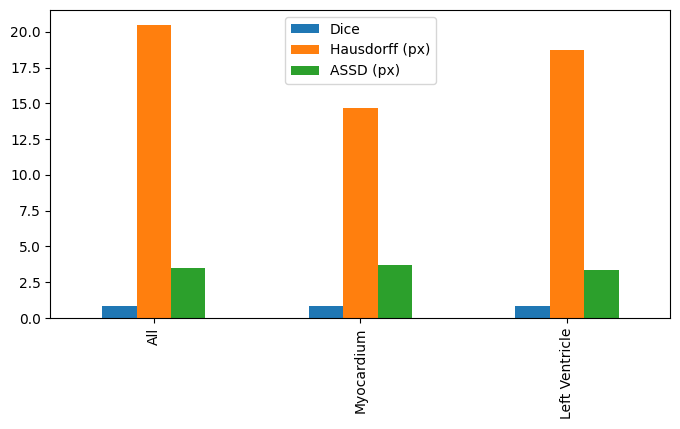

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.80it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.93,2.13
Myocardium,0.88,8.89,2.17
Left Ventricle,0.94,7.01,2.10


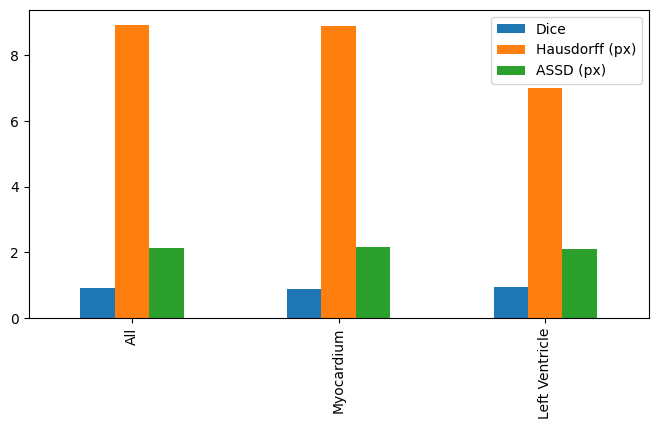

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 40.26it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.81,28.69,4.17
Myocardium,0.84,16.07,3.94
Left Ventricle,0.79,27.46,4.36


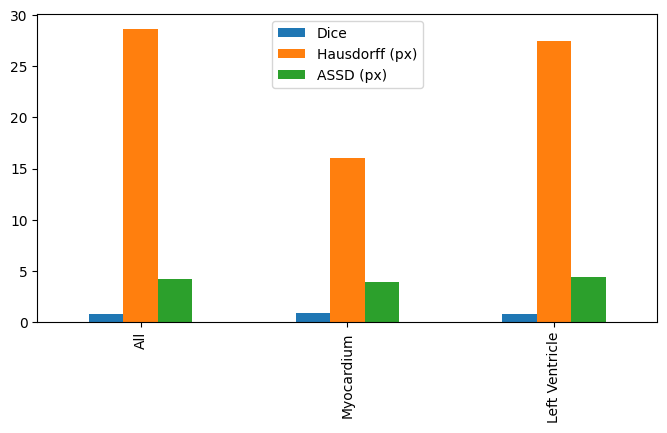

100/100 [==============================] - 1s 9ms/step


100%|██████████| 100/100 [00:02<00:00, 38.65it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.94,2.24
Myocardium,0.88,8.84,2.24
Left Ventricle,0.93,7.38,2.25


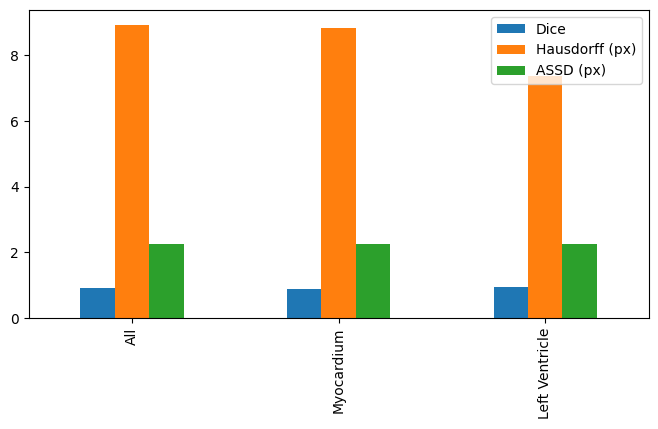

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.80,26.58,4.35
Myocardium,0.84,15.83,4.06
Left Ventricle,0.77,25.45,4.45


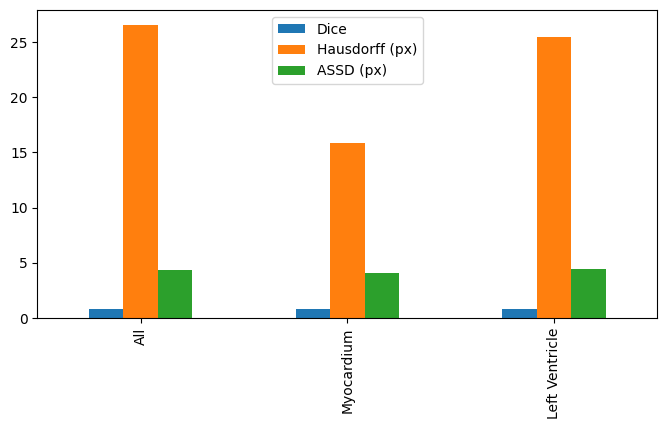

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.68it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,10.22,2.17
Myocardium,0.88,9.50,2.21
Left Ventricle,0.94,8.39,2.13


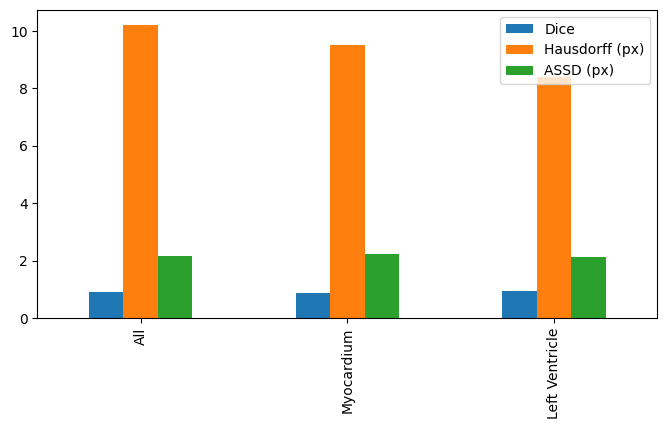

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 39.26it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.74,32.70,5.04
Myocardium,0.75,23.06,5.44
Left Ventricle,0.73,29.38,4.64


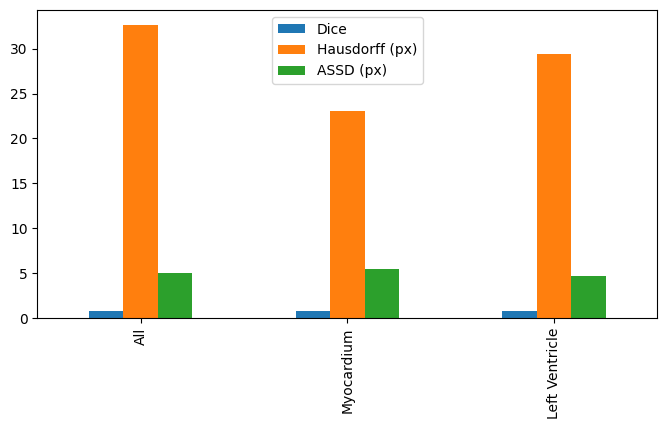

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.20it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.69,2.25
Myocardium,0.87,8.60,2.26
Left Ventricle,0.93,7.25,2.25


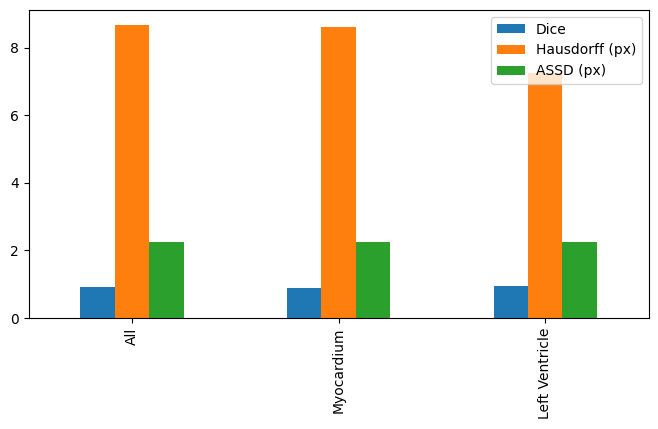

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.83it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.57,42.39,7.93
Myocardium,0.59,30.33,8.40
Left Ventricle,0.56,37.14,6.94


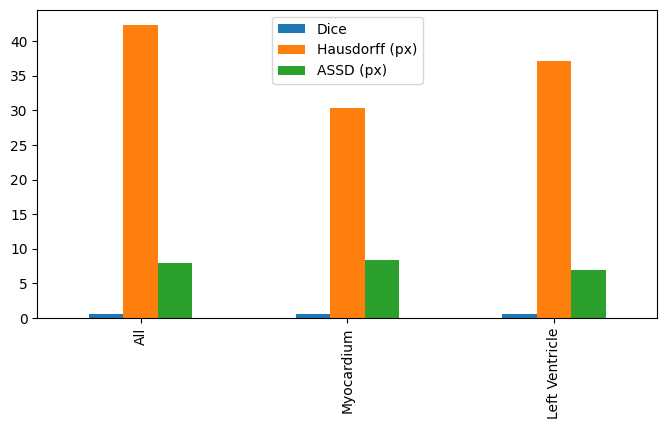

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.10it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.90,9.17,2.24
Myocardium,0.87,9.12,2.29
Left Ventricle,0.94,7.36,2.19


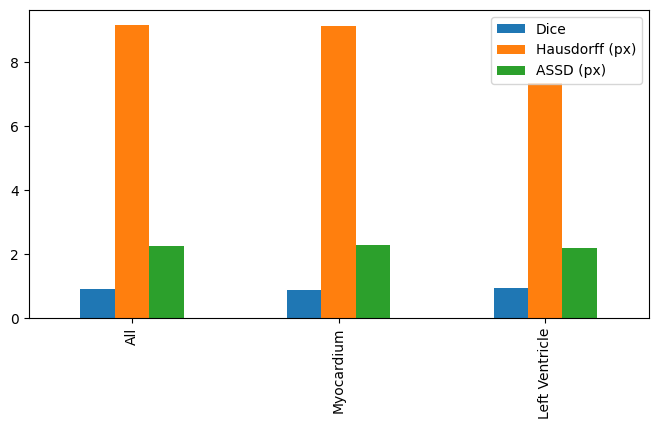

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 39.01it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.67,40.62,6.80
Myocardium,0.68,32.82,7.25
Left Ventricle,0.66,35.98,5.98


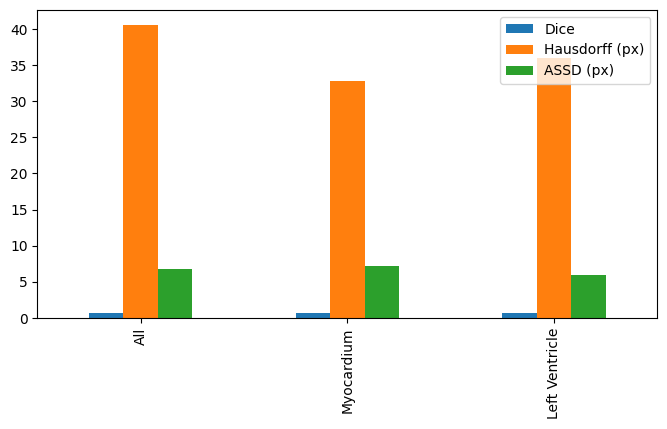

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.27it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,9.47,2.13
Myocardium,0.88,9.42,2.18
Left Ventricle,0.94,7.06,2.07


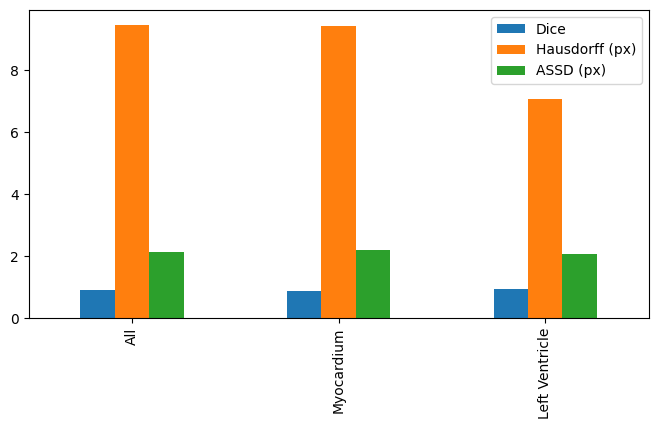

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.90it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.64,37.14,6.80
Myocardium,0.65,29.54,7.17
Left Ventricle,0.62,33.82,6.23


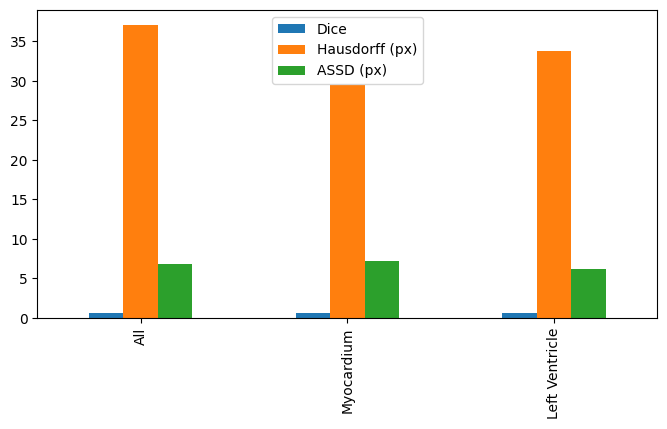

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 38.28it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.80,2.22
Myocardium,0.88,8.73,2.27
Left Ventricle,0.94,7.23,2.17


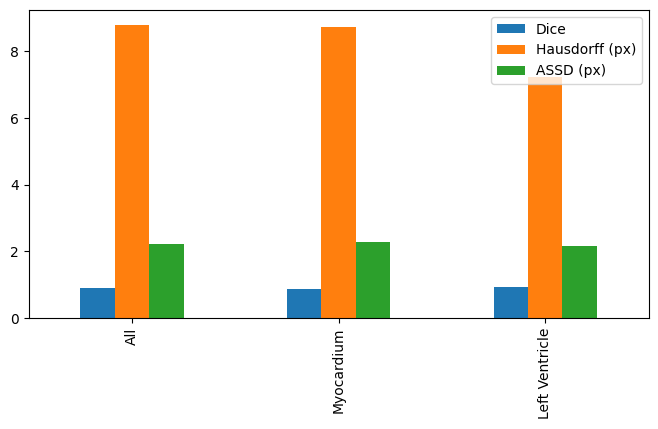

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 40.56it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.71,36.71,7.69
Myocardium,0.75,25.32,6.71
Left Ventricle,0.68,33.41,7.63


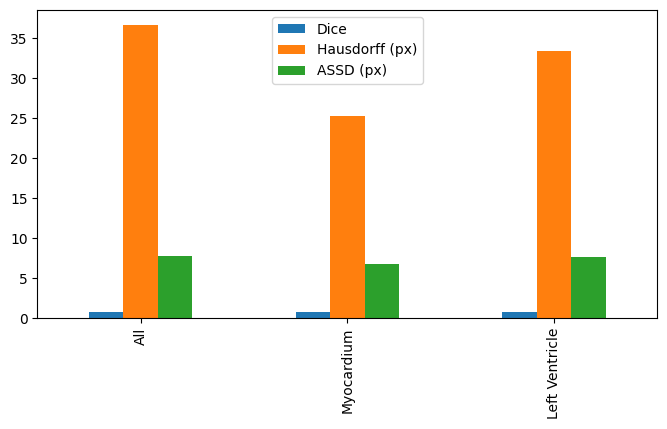

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.50it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.74,2.09
Myocardium,0.88,8.60,2.15
Left Ventricle,0.94,6.97,2.04


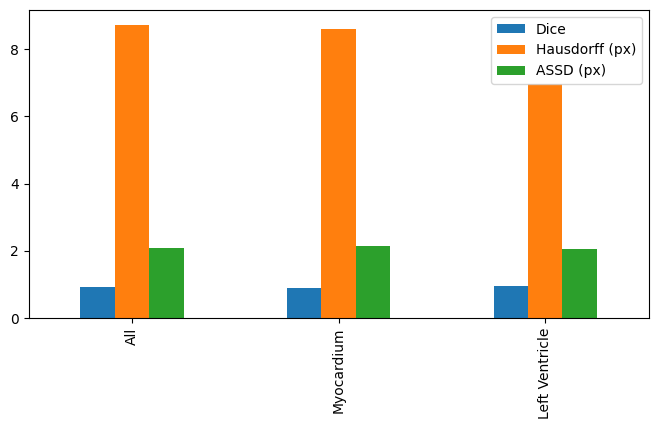

100/100 [==============================] - 1s 11ms/step


100%|██████████| 100/100 [00:02<00:00, 39.58it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.71,36.71,7.69
Myocardium,0.75,25.32,6.71
Left Ventricle,0.68,33.41,7.63


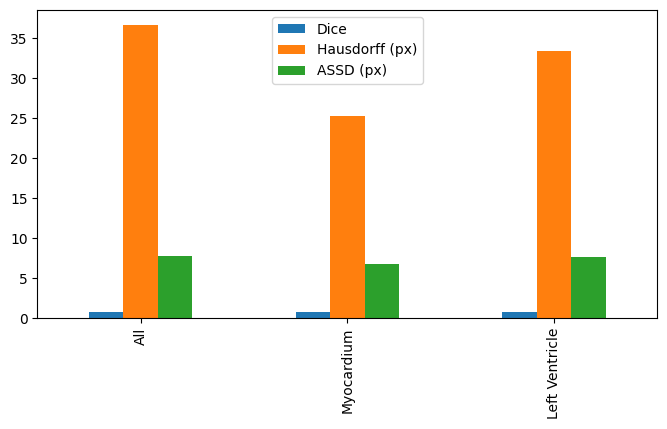

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.85it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.74,2.09
Myocardium,0.88,8.60,2.15
Left Ventricle,0.94,6.97,2.04


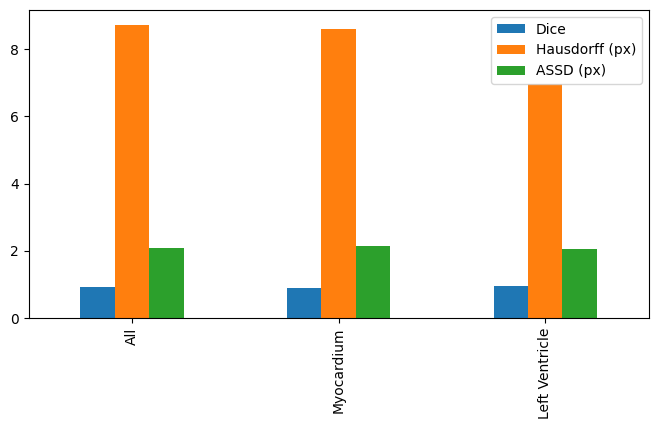

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.71,36.71,7.69
Myocardium,0.75,25.32,6.71
Left Ventricle,0.68,33.41,7.63


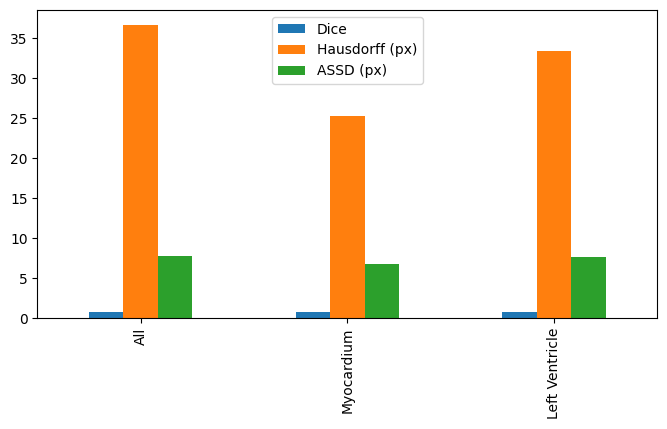

100/100 [==============================] - 1s 10ms/step


100%|██████████| 100/100 [00:02<00:00, 37.47it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,8.74,2.09
Myocardium,0.88,8.60,2.15
Left Ventricle,0.94,6.97,2.04


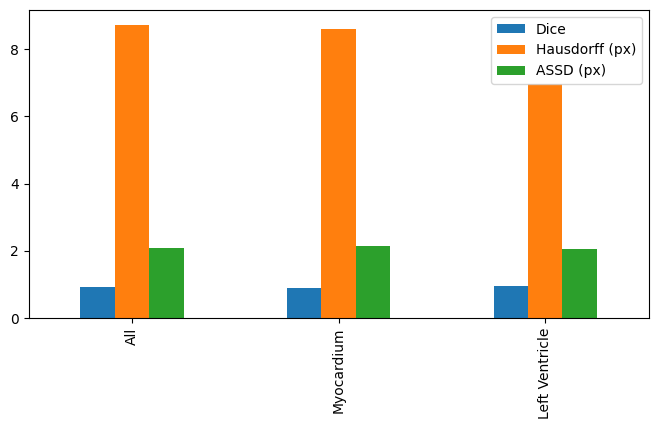

In [37]:
# Store results
dice_scores_SR = []
dice_scores_CR = []
dice_scores_SO = []
dice_scores_CO = []
dice_scores_SC = []
dice_scores_CC = []

# Evaluate and collect results
for size in sizes0:
    model_path_Random = f'./trained_model/BestModel/Unet_size{size}.h5'
    dice_scores_SR.append(EvaluateSUAMC(X_test_SA, y_test_SA, model_path_Random, size))
    dice_scores_CR.append(EvaluateCAMUS(X_test_C, y_test_C, model_path_Random, size))
    model_path_Outlier = f'./trained_model/BestModel/Outlier_Unet_size{size}.h5'
    dice_scores_SO.append(EvaluateSUAMC(X_test_SV, y_test_SV, model_path_Outlier, size))
    dice_scores_CO.append(EvaluateCAMUS(X_test_C, y_test_C, model_path_Outlier, size))
    model_path_Closest = f'./trained_model/BestModel/Closest_Unet_size{size}.h5'
    dice_scores_SC.append(EvaluateSUAMC(X_test_SV, y_test_SV, model_path_Closest, size))
    dice_scores_CC.append(EvaluateCAMUS(X_test_C, y_test_C, model_path_Closest, size))

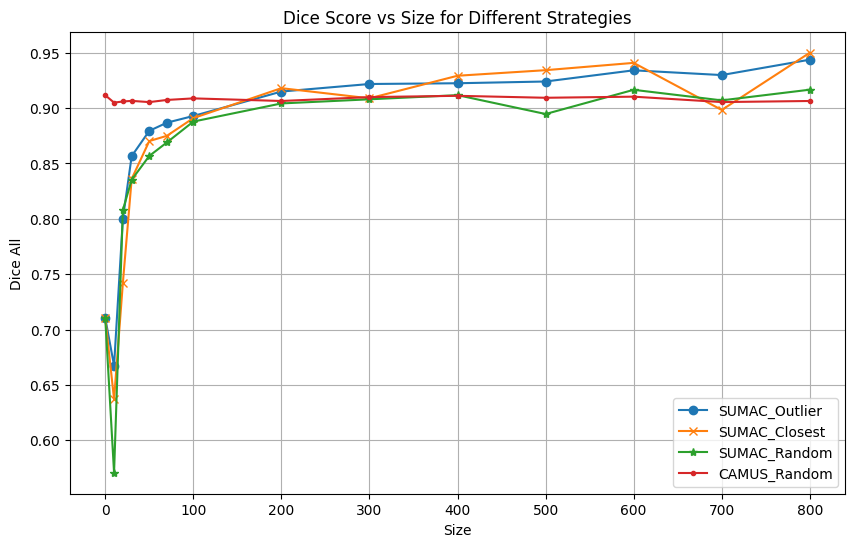

In [41]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sizes0, dice_scores_SO, marker='o', label='SUMAC_Outlier')
plt.plot(sizes0, dice_scores_SC, marker='x', label='SUMAC_Closest')
plt.plot(sizes0, dice_scores_SR, marker='*', label='SUMAC_Random')
plt.plot(sizes0, dice_scores_CR, marker='.', label='CAMUS_Random')
# plt.plot(sizes0, dice_scores_SC, marker='x', label='CAMUS_Outlier')
plt.xlabel('Size')
plt.ylabel('Dice All')
plt.title('Dice Score vs Size for Different Strategies')
plt.legend()
plt.grid(True)
plt.show()